In [ ]:
은행데이터를 보고 잠재적 부정행위를 저지르는 고객을 추출하기

이진수인 Class 종속변수를 통해 여부를 찾는게 아닌

지도학습을 통해 예측해본다.

신용카드 지원서 데이터 세트

15개의 뉴런을 통해 딥러닝 실행

뉴런 사이의 유클리드 거리를 계산하여

동떨어진 뉴런을 찾아 사기꾼인 것을 찾아낸다.

In [ ]:
인공 신경 회로망과 자기 조직화 지도를 합쳐서 해본다.

딥러닝을 하여 부정 행위를 저지를 가능성을 예측 

비지도학습에서 지도학습

In [33]:
dataset

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.460,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.000,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.750,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.500,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.170,2,6,4,1.960,1,1,14,0,2,60,159,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,15808223,1,31.57,10.500,2,14,4,6.500,1,0,0,0,2,0,1,1
686,15769980,1,20.67,0.415,2,8,4,0.125,0,0,0,0,2,0,45,0
687,15675450,0,18.83,9.540,2,6,4,0.085,1,0,0,0,2,100,1,1
688,15776494,0,27.42,14.500,2,14,8,3.085,1,1,1,0,2,120,12,1


In [1]:
# pip install MiniSom

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
dataset = pd.read_csv('Credit_Card_Applications.csv')
X = dataset.iloc[:, :-1].values 
y = dataset.iloc[:, -1].values

In [4]:
# 정규화 스케일링
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
X = sc.fit_transform(X)

# SOM 구현

In [5]:
from minisom import MiniSom
# 크기 정하기
som = MiniSom(x=10, y=10, input_len= 15, sigma= 1.0, learning_rate = 0.5)
som.random_weights_init(X)

# 100번 반복해서 훈련한다.
som.train_random(data = X, num_iteration = 100)

# 결과

2차원의 그리드에 최초 위닝 노드를 표기하고 각 위닝 노드마다 가장 중요한 정보인

평균 뉴런 거리를 볼 수 있다.

MID는 특정 위닝 노드와 주변의 이웃 위닝 노드 간의 평균거리를 뜻한다. 이웃간의 반지름을 뜻하는 sigma를 사용

즉, MID가 클수록 위닝노드와 이웃 간의 거리가 멀어진다. 

더 많은 위닝노드가 동떨어진 노드, 곧 아웃라이어(사기꾼)가 된다.

이런 방법으로 아웃라이어를 감지

뉴런마다 MID를 구하고 가장 큰 MID를 가진 위닝 노드를 가져온다.

숫자 대신 색깔로 사용 MID에 가까울소록 흰색으로 표현하였다.

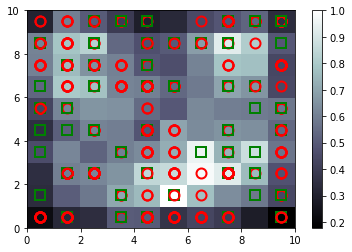

In [6]:
from pylab import bone, pcolor, colorbar, plot, show
bone() # 지도가 보일 창을 초기화
pcolor(som.distance_map().T) # 위닝노드를 색깔 지도로 불러오기
colorbar() # 색깔 범례(정규화된 MID값)
markers = ['o', 's'] # 빨간 동그라미는 거절, 녹색 네모는 승인받은 고객
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

(5,2),(6,3)좌표가 하얀 색이 나왔으므로 사기꾼이다.

고객 ID를 뽑아보자.

### 사기꾼 명단 만들기

In [7]:
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(5,2)], mappings[(6,3)]), axis = 0)
frauds = sc.inverse_transform(frauds)

In [8]:
print('Fraud Customer IDs')
for i in frauds[:, 0]:
  print(int(i))

Fraud Customer IDs
15704509
15686670
15624850
15660263
15615176
15748691
15727811
15665590
15720725
15572361


사기꾼 명단만 만드는 것이 아니라 고객 명단 중 사기를 칠 가능성을 찾아본다.

In [9]:
# 특성 행렬 만들기 (Feature Matrix)
new_X = dataset.iloc[:, 1:].values 


In [10]:
# 종속 변수 만들기 
# 사기꾼은 1로 설정
fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
    if dataset.iloc[i,0] in frauds:
        fraud[i] = 1

# ANN 구현

In [11]:
# 표준화 작업
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
new_X = sc.fit_transform(new_X)

In [14]:
from keras.models import Sequential
from keras.layers import Dense

In [15]:
classifier = Sequential()

In [17]:
classifier.add(Dense(units=2, kernel_initializer = 'uniform', activation='relu', input_dim = 15))

classifier.add(Dense(units=1, kernel_initializer = 'uniform', activation='sigmoid'))

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

classifier.fit(new_X, fraud, batch_size = 1, epochs = 5)

Epoch 1/5
690/690 [==============================] - 2s 2ms/step - loss: 0.4548 - accuracy: 0.9855
Epoch 2/5
690/690 [==============================] - 1s 2ms/step - loss: 0.1666 - accuracy: 0.9855
Epoch 3/5
690/690 [==============================] - 2s 2ms/step - loss: 0.0884 - accuracy: 0.9855
Epoch 4/5
690/690 [==============================] - 1s 2ms/step - loss: 0.0708 - accuracy: 0.9855
Epoch 5/5
690/690 [==============================] - 1s 2ms/step - loss: 0.0642 - accuracy: 0.9855


In [30]:
y_pred = classifier.predict(new_X)
y_pred = np.concatenate((dataset.iloc[:,0:1],y_pred), axis = 1)

22/22 [==============================] - 0s 2ms/step


In [32]:
y_pred = y_pred[y_pred[:,1].argsort()]
np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.6f}".format(x)})
y_pred

array([[15757434.000000, 0.000188],
       [15699340.000000, 0.000316],
       [15673907.000000, 0.000327],
       ...,
       [15623668.000000, 0.135021],
       [15660263.000000, 0.141137],
       [15594133.000000, 0.197383]])

0.02% 확률부터 20% 확률까지 고객이 사기를 칠 가능성에 대해 예측을 하였다.